In [1]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, geom_line, geom_smooth,
    aes, facet_wrap, labs,
    scale_x_log10, scale_y_continuous, scale_y_log10,
)
import patchworklib as pw
import numpy as np

from llm_ran.benchmark.metrics import pass_at, pass_power
import plotnine as pn
my_theme = lambda x, y: pn.theme_classic() + pn.theme(
    # axis_text_x=pn.element_text(rotation=15, hjust=1),
    panel_grid_major_y=pn.element_line(size=0.5, color="grey"),
    panel_border=pn.element_rect(size=1, color="black"),
    figure_size=(x, y)
)

<Figure size 100x100 with 0 Axes>

In [2]:
DATA_PATH = "../data"
OUTPUT_PATH = "../../thesis/figures"
df = pd.read_csv(f"{DATA_PATH}/processed/combined.csv", index_col=0)
df = df[(df['scenario'] == "base") & (df['model'].str.startswith('qwen2.5:'))]
df['model_size'] = df['model'].str.split(':').str[1].str.replace('b', '').str.replace('8x', '').astype(float)
df = df.rename(columns={"chain": "agent"})
df.columns


Index(['scenario', 'question', 'trial', 'run_id', 'model', 'agent',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file',
       'can_answer', 'correct', 'pass', 'deviation', 'model_size'],
      dtype='object')

In [3]:
group_by = ["model_size", "agent"]
metrics = ["can_answer", "correct", 'execution_time', "total_tokens", "num_messages", "pass"]
agg1 = {
    "can_answer@5": ('can_answer', pass_at(5)),
    "can_answer@1": ('can_answer', pass_at(1)),
    "can_answer^5": ('can_answer', pass_power(5)),
    "can_answer@10": ('can_answer', pass_at(10)),
    "can_answer^10": ('can_answer', pass_power(10)),
    "correct@5": ('correct', pass_at(5)),
    "correct@1": ('correct', pass_at(1)),
    "correct^5": ('correct', pass_power(5)),
    "correct@10": ('correct', pass_at(10)),
    "correct^10": ('correct', pass_power(10)),
    "pass@5": ('pass', pass_at(5)),
    "pass@1": ('pass', pass_at(1)),
    "pass^5": ('pass', pass_power(5)),
    "pass@10": ('pass', pass_at(10)),
    "pass^10": ('pass', pass_power(10)),
    "execution_time": ('execution_time', 'mean'),
    "total_tokens": ('total_tokens', 'mean'),
    "num_messages": ('num_messages', 'mean'),
}
groupby1 = ["scenario", "question"]

raw = df.groupby(group_by + groupby1)[metrics].agg(**agg1).reset_index()
display(raw)
raw_pivoted = raw.melt(
    id_vars=group_by,
    value_vars=[*agg1.keys()],
    var_name="metric",
    value_name="value",
)
raw_grouped = raw_pivoted.groupby(
    group_by + ["metric"]
).agg(
    value_min=('value', 'min'),
    value_max=('value', 'max'),
    value=('value', 'mean'),
    value_25=('value', lambda x: x.quantile(0.25)),
    # value_50=('value', lambda x: x.quantile(0.5)),
    value_75=('value', lambda x: x.quantile(0.75)),
).reset_index()
display(raw_grouped)

# resampled = df.groupby(group_by + groupby1)[metrics].agg(**agg1).reset_index().groupby(group_by)[list(agg1.keys())].agg('mean').join(
#     df.groupby(group_by)[list(agg.keys())].agg('mean'), on=group_by
# ).reset_index()
# # resampled = df.groupby(group_by)[metrics].agg(**agg).reset_index()
# display(resampled)
# pivoted = resampled.melt(
#     id_vars=group_by,
#     value_vars=[*agg.keys(), *agg1.keys()],
#     var_name="metric",
#     value_name="value",
# )
# display(pivoted)

,model_size,agent,scenario,question,can_answer@5,can_answer@1,can_answer^5,can_answer@10,can_answer^10,correct@5,...,correct@10,correct^10,pass@5,pass@1,pass^5,pass@10,pass^10,execution_time,total_tokens,num_messages
0,0.5,codegen,base,how-many-nodes,0.870872,0.30,2.430000e-03,0.994582,5.904900e-06,0.447368,...,0.763158,1.000000e-10,0.000000,0.00,0.000000e+00,0.000000,0.000000e+00,0.490571,1693.40,4.85
1,0.5,codegen,base,how-many-nodes-does-a-deployment-use,0.000000,0.00,0.000000e+00,0.000000,0.000000e+00,0.250000,...,0.500000,9.765625e-14,0.000000,0.00,0.000000e+00,0.000000,0.000000e+00,0.810309,2451.40,5.60
2,0.5,codegen,base,how-many-pods-for-deployment,0.600877,0.15,7.593750e-05,0.894737,5.766504e-09,0.600877,...,0.894737,5.766504e-09,0.250000,0.05,3.125000e-07,0.500000,9.765625e-14,0.813163,2565.90,6.00
3,0.5,codegen,base,how-many-pods-for-service,0.447368,0.10,1.000000e-05,0.763158,1.000000e-10,0.806308,...,0.983746,9.536743e-07,0.447368,0.10,1.000000e-05,0.763158,1.000000e-10,1.285094,5245.35,10.85
4,0.5,codegen,base,how-many-pods-in-namespace,0.250000,0.05,3.125000e-07,0.500000,9.765625e-14,0.447368,...,0.763158,1.000000e-10,0.000000,0.00,0.000000e+00,0.000000,0.000000e+00,0.979617,3680.90,8.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,72.0,direct,base,how-many-services-in-namespace,1.000000,0.80,3.276800e-01,1.000000,1.073742e-01,0.806308,...,0.983746,9.536743e-07,0.600877,0.15,7.593750e-05,0.894737,5.766504e-09,1.332364,2380.15,4.00
164,72.0,direct,base,how-much-cpu-for-deployment-per-pod,0.948916,0.40,1.024000e-02,0.999643,1.048576e-04,0.983746,...,0.999995,9.765625e-04,0.948916,0.40,1.024000e-02,0.999643,1.048576e-04,1.538181,2310.35,4.00
165,72.0,direct,base,how-much-cpu-for-deployment-total,0.970201,0.45,1.845281e-02,0.999940,3.405063e-04,0.000000,...,0.000000,0.000000e+00,0.000000,0.00,0.000000e+00,0.000000,0.000000e+00,2.922236,3337.45,5.60
166,72.0,direct,base,how-much-memory-for-deployment-per-pod,0.870872,0.30,2.430000e-03,0.994582,5.904900e-06,0.983746,...,0.999995,9.765625e-04,0.870872,0.30,2.430000e-03,0.994582,5.904900e-06,1.566134,2315.50,4.00


,model_size,agent,metric,value_min,value_max,value,value_25,value_75
0,0.5,codegen,can_answer@1,0.00,0.300000,8.750000e-02,3.750000e-02,1.125000e-01
1,0.5,codegen,can_answer@10,0.00,0.994582,5.477941e-01,3.750000e-01,7.960526e-01
2,0.5,codegen,can_answer@5,0.00,0.870872,3.470610e-01,1.875000e-01,4.857456e-01
3,0.5,codegen,can_answer^10,0.00,0.000006,4.930611e-07,7.324219e-14,1.516626e-09
4,0.5,codegen,can_answer^5,0.00,0.002430,2.177344e-04,2.343750e-07,2.648437e-05
...,...,...,...,...,...,...,...,...
247,72.0,direct,pass@10,0.00,1.000000,8.986415e-01,9.696207e-01,1.000000e+00
248,72.0,direct,pass@5,0.00,1.000000,8.346771e-01,8.033733e-01,9.999516e-01
249,72.0,direct,pass^10,0.00,1.000000,1.248275e-01,4.430117e-06,9.145374e-02
250,72.0,direct,pass^5,0.00,1.000000,2.082830e-01,1.841484e-03,2.889048e-01


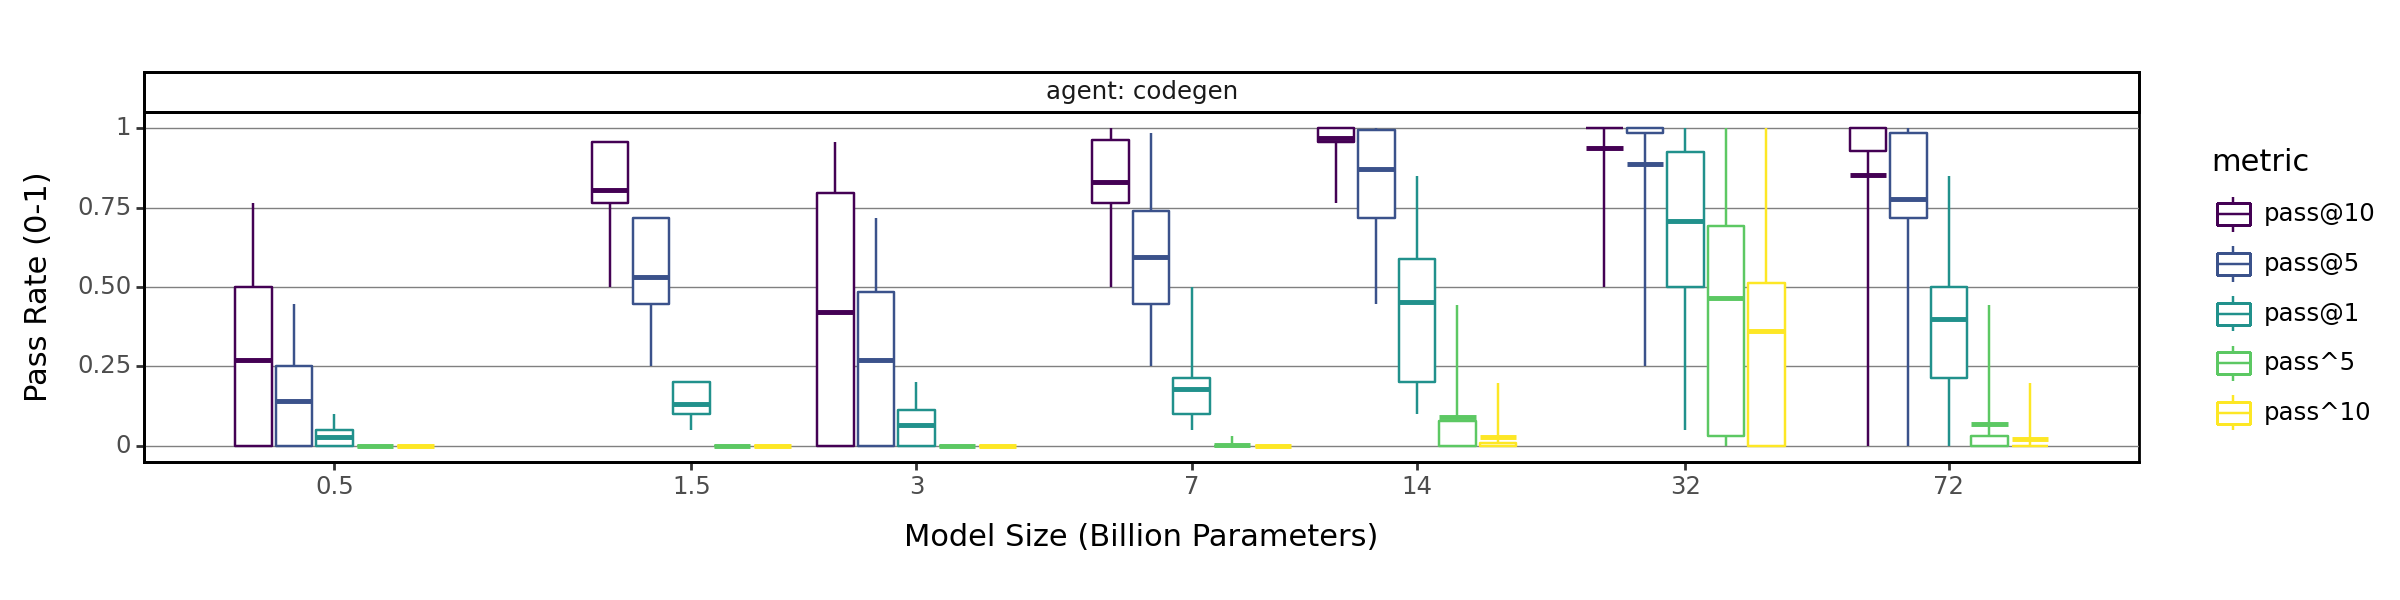

<Figure Size: (1200 x 300)>

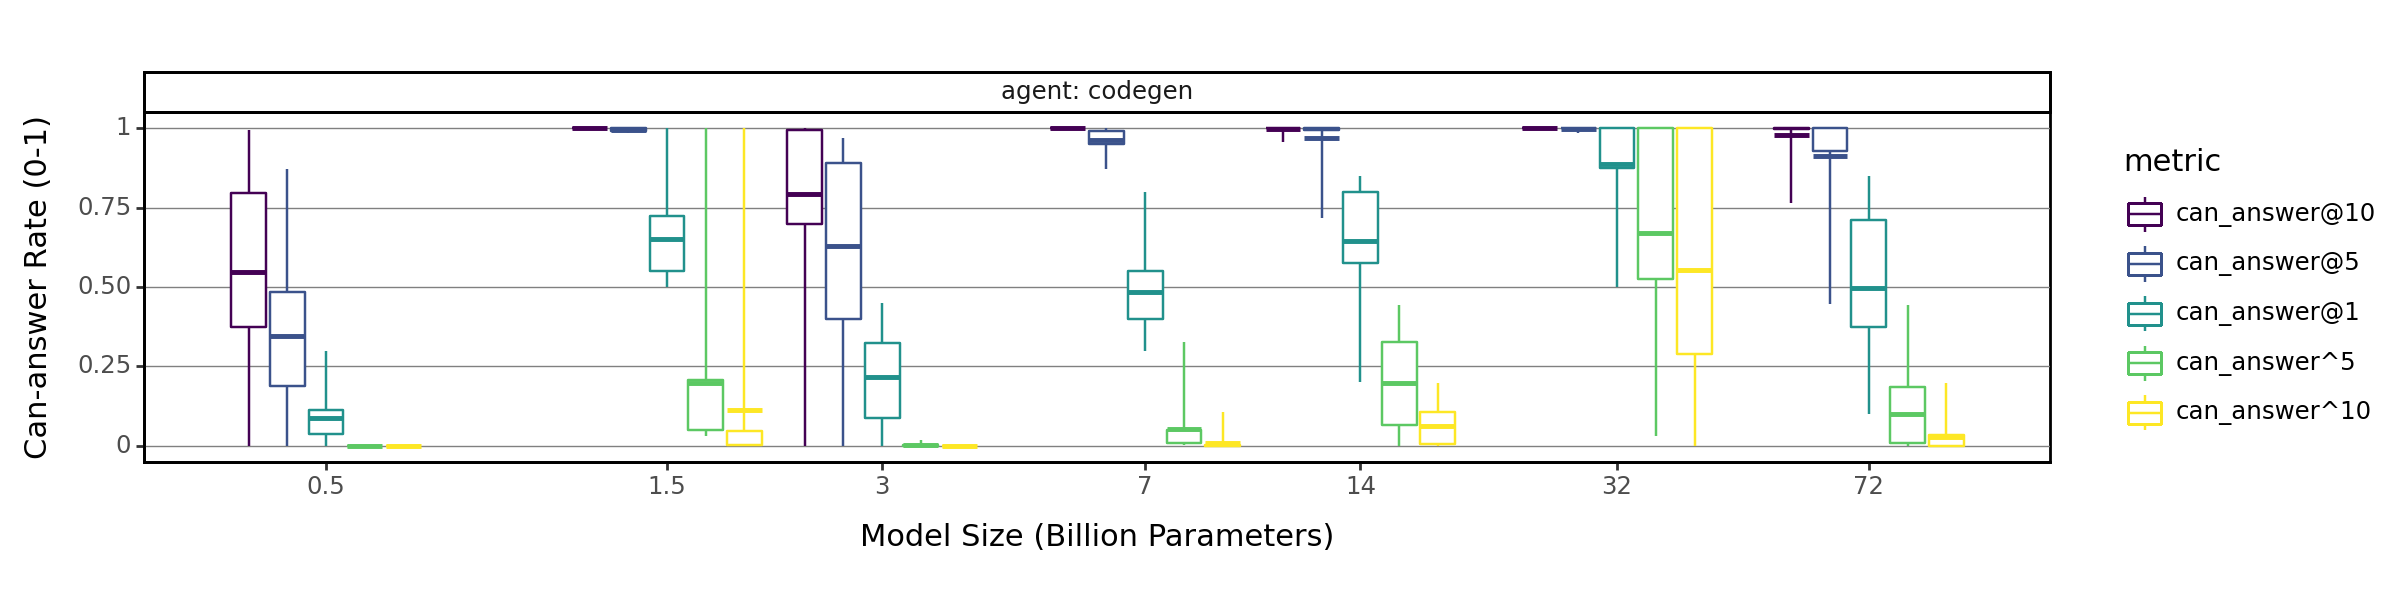

<Figure Size: (1200 x 300)>

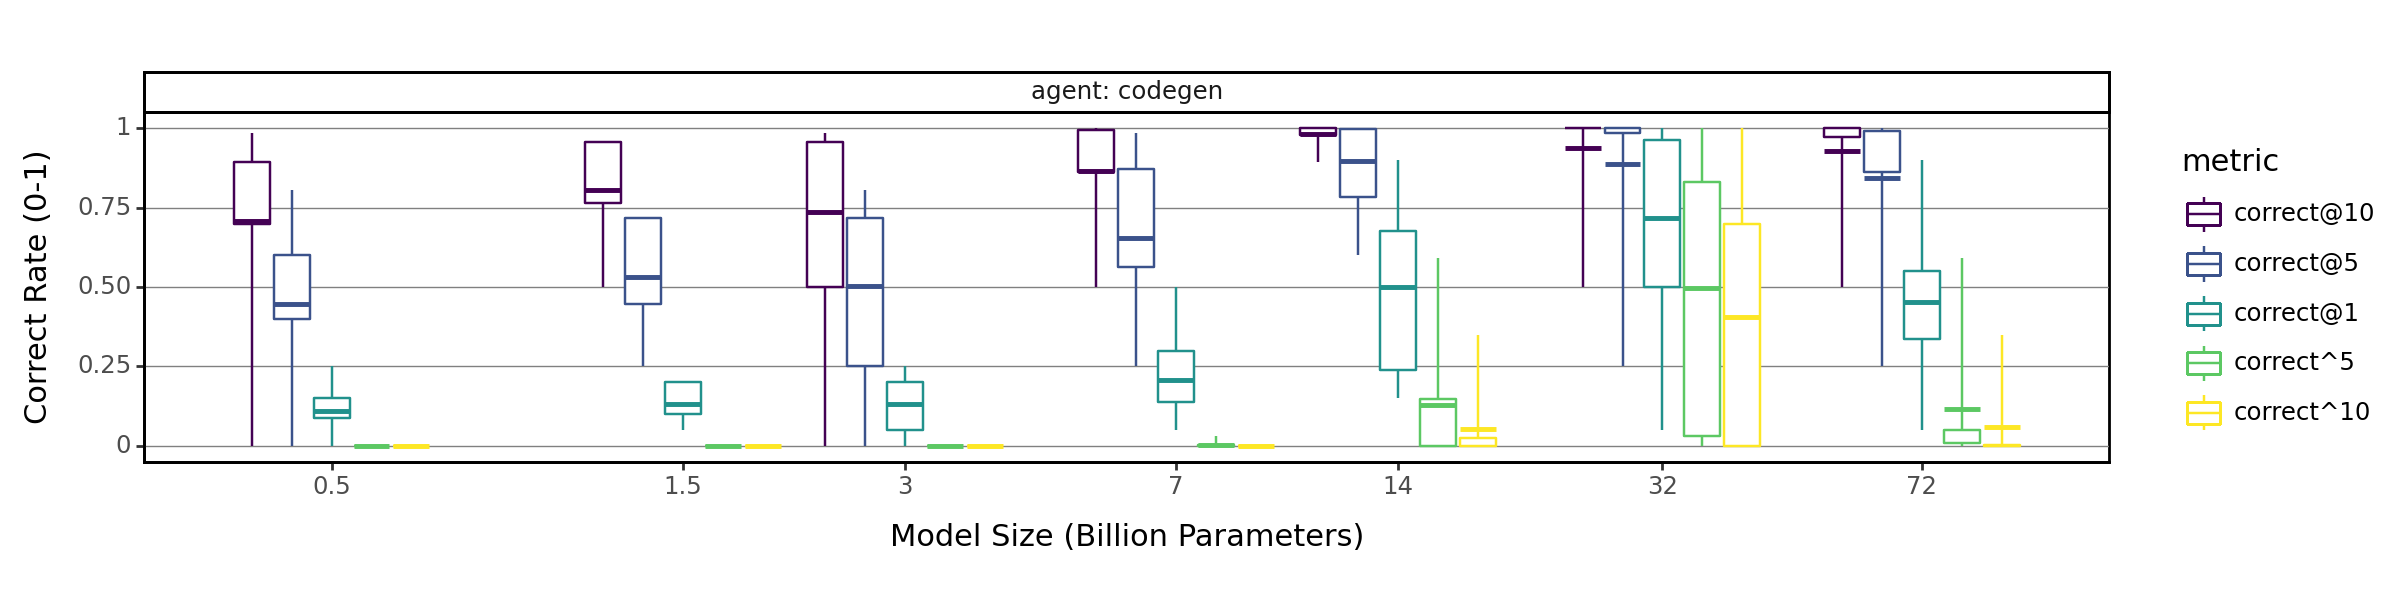

<Figure Size: (1200 x 300)>

In [4]:
def draw_metrics(data, metrics, ylabel, width=12, height=3):
    _data = data[data['metric'].isin(metrics)].copy()
    _data["metric"] = pd.Categorical(_data["metric"], categories=metrics, ordered=True)

    return (
        ggplot(_data)
        + pn.geom_boxplot(aes(x="factor(model_size)", ymin="value_min", lower="value_25", middle="value", upper="value_75", ymax="value_max", color="metric"), position="dodge2", stat = "identity")
        + facet_wrap("~agent", labeller="label_both")
        + scale_x_log10(
            breaks=data['model_size'].unique(),
        )
        + labs(
            x='Model Size (Billion Parameters)',
            y=ylabel,
            fill="metric",
        )
        + my_theme(width, height)
    )

codegen = raw_grouped[raw_grouped['agent'] == "codegen"]

_pass_metrics = [
    "pass@10",
    "pass@5",
    "pass@1",
    "pass^5",
    "pass^10",
]
_can_answer_metrics = [
    "can_answer@10",
    "can_answer@5",
    "can_answer@1",
    "can_answer^5",
    "can_answer^10",
]
_correct_metrics = [
    "correct@10",
    "correct@5",
    "correct@1",
    "correct^5",
    "correct^10",
]


_g0 = draw_metrics(codegen, _pass_metrics, ylabel="Pass Rate (0-1)", width=12, height=3)
_g1 = draw_metrics(codegen, _can_answer_metrics, ylabel="Can-answer Rate (0-1)", width=12, height=3)
_g2 = draw_metrics(codegen, _correct_metrics, ylabel="Correct Rate (0-1)", width=12, height=3)

display(_g0)
display(_g1)
display(_g2)

_g0.save(f"{OUTPUT_PATH}/scaling_pass.png", bbox_inches='tight', dpi=300)
_g1.save(f"{OUTPUT_PATH}/scaling_can_answer.png", bbox_inches='tight', dpi=300)
_g2.save(f"{OUTPUT_PATH}/scaling_correct.png", bbox_inches='tight', dpi=300)

# _figsize = (12, 3)
# _g = (
#     pw.load_ggplot(_g0)
#     / pw.load_ggplot(_g1)
#     / pw.load_ggplot(_g2)
# )
# # _g.set_suptitle("Scaling Performance of Qwen-2.5 Models")
# _g.savefig(f"{OUTPUT_PATH}/scaling_performance.png", bbox_inches='tight')

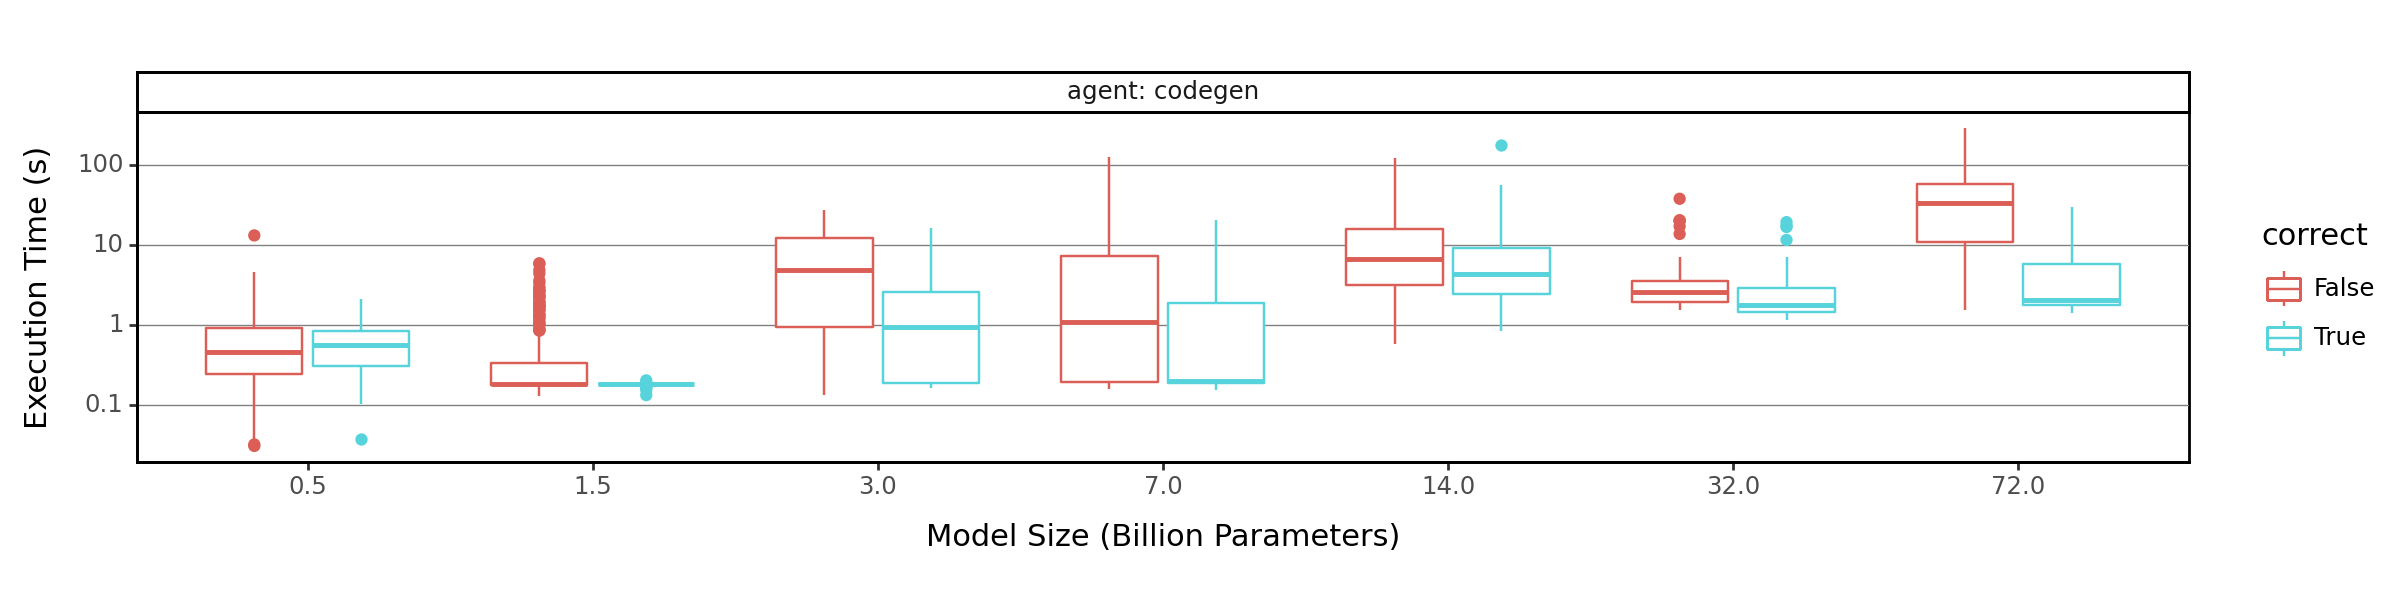

<Figure Size: (1200 x 300)>

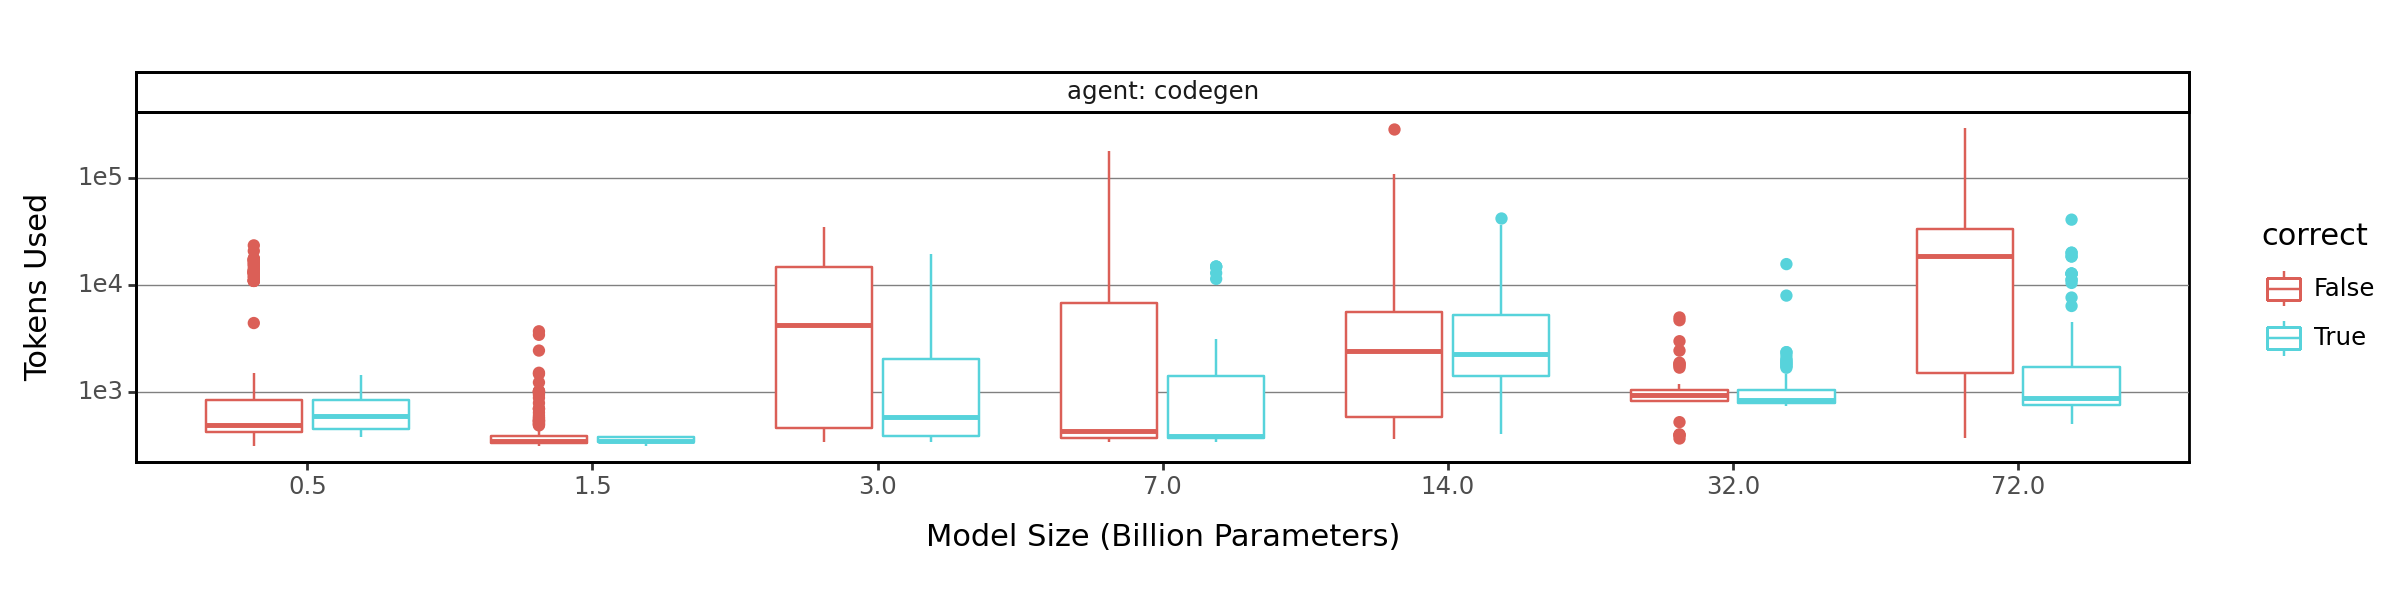

<Figure Size: (1200 x 300)>

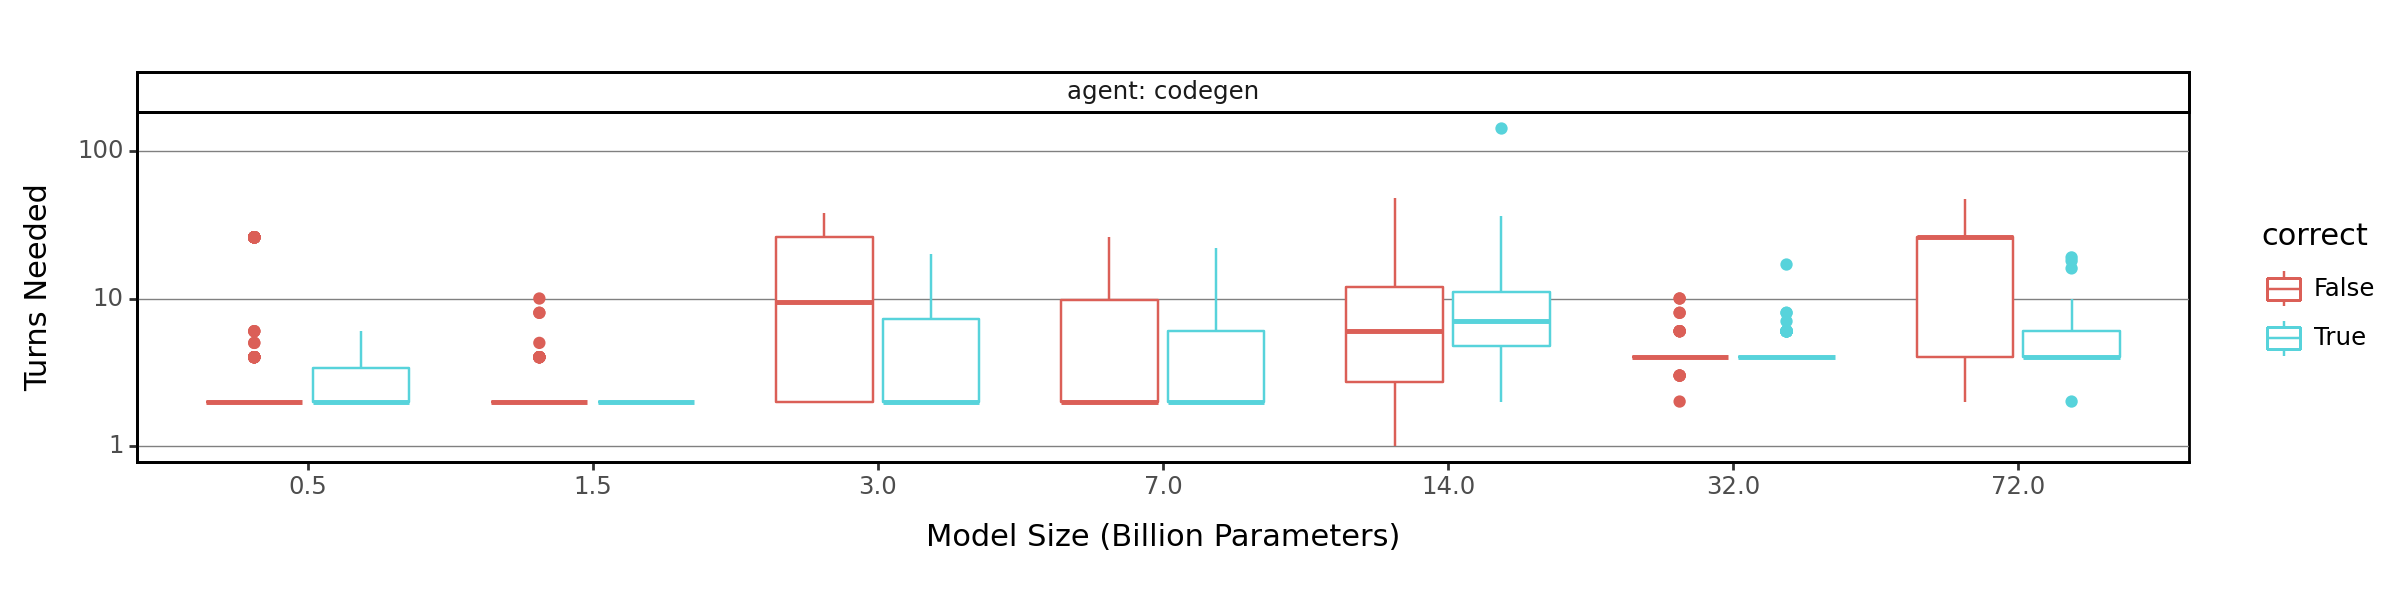

<Figure Size: (1200 x 300)>

In [5]:
# Model size vs. execution time
breaks = df['model_size'].unique()
codegen_cost = df[df['agent'] == 'codegen']
_g1 = (
    ggplot(codegen_cost, aes(x='factor(model_size)', y="execution_time", color="correct"))
    # + geom_point()
    + pn.geom_boxplot(position="dodge2")
    # + geom_smooth(method='lm')
    # + scale_x_log10(
    #     breaks=breaks,
    #     labels=breaks,
    # )
    + scale_y_log10()
    + facet_wrap('agent', labeller="label_both")
    + labs(
        x='Model Size (Billion Parameters)',
        y='Execution Time (s)',
        # title='Execution Time vs Model Size',
    )
    + my_theme(12, 3)
)
_g2 = (
    ggplot(codegen_cost, aes(x='factor(model_size)', y="total_tokens", color="correct"))
    # + geom_point()
    # + geom_smooth(method='lm')
    + pn.geom_boxplot(position="dodge2")
    # + scale_x_log10(
    #     breaks=breaks,
    #     # labels=breaks,
    # )
    + scale_y_log10()
    + facet_wrap('agent', labeller="label_both")
    + labs(
        x='Model Size (Billion Parameters)',
        y='Tokens Used',
        # title='Tokens Used vs Model Size',
    )
    + my_theme(12, 3)
)
_g3 = (
    ggplot(codegen_cost, aes(x='factor(model_size)', y="num_messages", color="correct"))
    # + geom_point()
    # + geom_smooth(method='lm')
    + pn.geom_boxplot(position="dodge2")
    # + scale_x_log10(
    #     breaks=breaks,
    #     # labels=breaks,
    # )
    + scale_y_log10()
    + facet_wrap('agent', labeller="label_both")
    + labs(
        x='Model Size (Billion Parameters)',
        y='Turns Needed',
        # title='Tokens Used vs Model Size',
    )
    + my_theme(12, 3)
)

display(_g1)
display(_g2)
display(_g3)
_g1.save(f"{OUTPUT_PATH}/scaling_execution_time.png", bbox_inches='tight', dpi=300)
_g2.save(f"{OUTPUT_PATH}/scaling_total_tokens.png", bbox_inches='tight', dpi=300)
_g3.save(f"{OUTPUT_PATH}/scaling_num_messages.png", bbox_inches='tight', dpi=300)
